# Function defs EXPERT

Esta tabla contiene la información de las definiciones de funciones.  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

TARGET_FEATURE = 'functiondef__expertise_level'
TARGET_CLASS = 'EXPERT'
full_table = get_data('functiondefs')

instances_for_class_low = len(full_table[full_table[TARGET_FEATURE] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TARGET_FEATURE] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low} ({instances_for_class_low/len(full_table)*100:.4}%) instances for BEGINNER class and {instances_for_class_high} ({instances_for_class_high/len(full_table)*100:.4}%) for EXPERT class.")

2024-05-23 10:50:26.499928 Data cache files found ...
2024-05-23 10:50:26.514438 Data cache files successfully loaded!!
The dataset contains 24207 (43.77%) instances for BEGINNER class and 31096 (56.23%) for EXPERT class.


In [2]:
full_table = full_table[full_table[TARGET_FEATURE] == TARGET_CLASS]

# Table name, features and target.
TABLE_NAME = 'functiondefs'
TABLE_FEATURES = ['functiondef__name_convention', 'functiondef__number_of_characters', 'functiondef__is_magic', 'functiondef__is_private', 'functiondef__body_count', 'functiondef__expressions_pct', 'functiondef__is_async', 'functiondef__number_of_decorators', 'functiondef__has_return_type_annotation', 'functiondef__has_doc_string', 'functiondef__height', 'functiondef__type_annotations_pct']

# Load features and target.
X = full_table[TABLE_FEATURES]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

Features shape: (31096, 12)
As we can see the downloaded data contains a total of 31096 instances. For each instance we have 12 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [3]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31096 entries, 14769 to 54837
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   functiondef__name_convention             31096 non-null  object 
 1   functiondef__number_of_characters        31096 non-null  int64  
 2   functiondef__is_magic                    31096 non-null  bool   
 3   functiondef__is_private                  31096 non-null  bool   
 4   functiondef__body_count                  31096 non-null  int64  
 5   functiondef__expressions_pct             31096 non-null  float64
 6   functiondef__is_async                    31096 non-null  bool   
 7   functiondef__number_of_decorators        31096 non-null  int64  
 8   functiondef__has_return_type_annotation  31096 non-null  bool   
 9   functiondef__has_doc_string              31096 non-null  bool   
 10  functiondef__height                      31096 

Cómo podemos ver la tabla está compuesta por 6 variables numéricas, 5 variables boleanas y dos de tipo objeto. 

### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [55.91%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

functiondef__name_convention               0
functiondef__number_of_characters          0
functiondef__is_magic                      0
functiondef__is_private                    0
functiondef__body_count                    0
functiondef__expressions_pct               0
functiondef__is_async                      0
functiondef__number_of_decorators          0
functiondef__has_return_type_annotation    0
functiondef__has_doc_string                0
functiondef__height                        0
functiondef__type_annotations_pct          0
dtype: int64

In [6]:
print_empty_cols(X)

functiondef__name_convention
----------------------------
0 instancias no tienen un valor para la columna functiondef__name_convention


functiondef__number_of_characters
---------------------------------
0 instancias no tienen un valor para la columna functiondef__number_of_characters


functiondef__is_magic
---------------------
0 instancias no tienen un valor para la columna functiondef__is_magic


functiondef__is_private
-----------------------
0 instancias no tienen un valor para la columna functiondef__is_private


functiondef__body_count
-----------------------
0 instancias no tienen un valor para la columna functiondef__body_count


functiondef__expressions_pct
----------------------------
0 instancias no tienen un valor para la columna functiondef__expressions_pct


functiondef__is_async
---------------------
0 instancias no tienen un valor para la columna functiondef__is_async


functiondef__number_of_decorators
---------------------------------
0 instancias no tienen un valo

### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
functiondef__name_convention,31096,7,SnakeCase,25477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_characters,31096.0,NaN,NaN,NaN,17.759004,10.24914,1.0,10.0,16.0,23.0,87.0
functiondef__is_magic,31096,2,False,31041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__is_private,31096,2,False,27297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__body_count,31096.0,NaN,NaN,NaN,4.968549,5.526603,1.0,2.0,3.0,6.0,172.0
functiondef__expressions_pct,31096.0,NaN,NaN,NaN,0.20213,0.263943,0.0,0.0,0.1,0.333333,1.0
functiondef__is_async,31096,2,False,30208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_decorators,31096.0,NaN,NaN,NaN,0.311037,0.743642,0.0,0.0,0.0,1.0,46.0
functiondef__has_return_type_annotation,31096,2,False,22295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__has_doc_string,31096,2,False,21937,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "functiondef__expressions_pct": [(0.0, 0.0), (0.0, 0.5), (0.5, 1.0), (1.0, inf)], # min: 0 ; max: 1
    "functiondef__number_of_decorators": [(0.0, 0.0), (0.0, inf)], # min: 0 ; max: 46
    "functiondef__type_annotations_pct": [(0.0, 0.0), (0.0, 1.0), (1.0, inf)], # min: 0 ; max: 1
    "functiondef__number_of_characters": [(1.0, 8.0), (8.0, 12), (12, 18), (18, inf)], # min: 1 ; max: 87
    "functiondef__body_count": [(1.0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, inf)], # min: 1 ; max: 364
    "functiondef__height": [(1.0, 1.0), (1.0, 1.9), (2.0, 2.0), (2.0, inf)], # min: 1 ; max: 10
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['functiondef__expressions_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_decorators'], 10))
print(get_statistics(X_copy, ['functiondef__type_annotations_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_characters'], 10))
print(get_statistics(X_copy, ['functiondef__body_count'], 10))
print(get_statistics(X_copy, ['functiondef__height'], 10))
print(get_statistics(X_copy, ['functiondef__name_convention'], 10))
print(get_statistics(X_copy, ['functiondef__is_private'], 10))
print(get_statistics(X_copy, ['functiondef__is_magic'], 10))
print(get_statistics(X_copy, ['functiondef__is_async'], 10))
print(get_statistics(X_copy, ['functiondef__has_return_type_annotation'], 10))
print(get_statistics(X_copy, ['functiondef__has_doc_string'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_SnakeCase'], 10))
#print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_Lower'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
functiondef__expressions_pct  count  percentage
                   [0.0_0.0]  14774   47.510934
                   [0.0_0.5)  10711   34.444945
                   [0.5_1.0)   4245   13.651273
                   [1.0_inf]   1366    4.392848

functiondef__number_of_decorators  count  percentage
                        [0.0_0.0]  23263   74.810265
                        [0.0_inf]   7833   25.189735

functiondef__type_annotations_pct  count  percentage
                        [0.0_0.0]  20024   64.394134
                        [1.0_inf]   8447   27.164266
                        [0.0_1.0)   2625    8.441600

functiondef__number_of_characters  count  percentage
                         [18_inf]  13977   44.947903
                          [12_18)   7879   25.337664
                         [8.0_12)   4897   15.748006
                        [1.0_8.0)   4343   13.966427

functiondef__body_count  count  percentage
              [5.0_inf]  11330   36.435554
           

In [9]:
def normalize_datatypes(X:pd.DataFrame) -> (pd.DataFrame, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')        
    columns_names = X.columns.tolist()
    return X, columns_names

X, TABLE_FEATURES = normalize_datatypes(X)
# Print information about the loaded table
print(f'Features shape: {X.shape}')

Features shape: (31096, 18)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

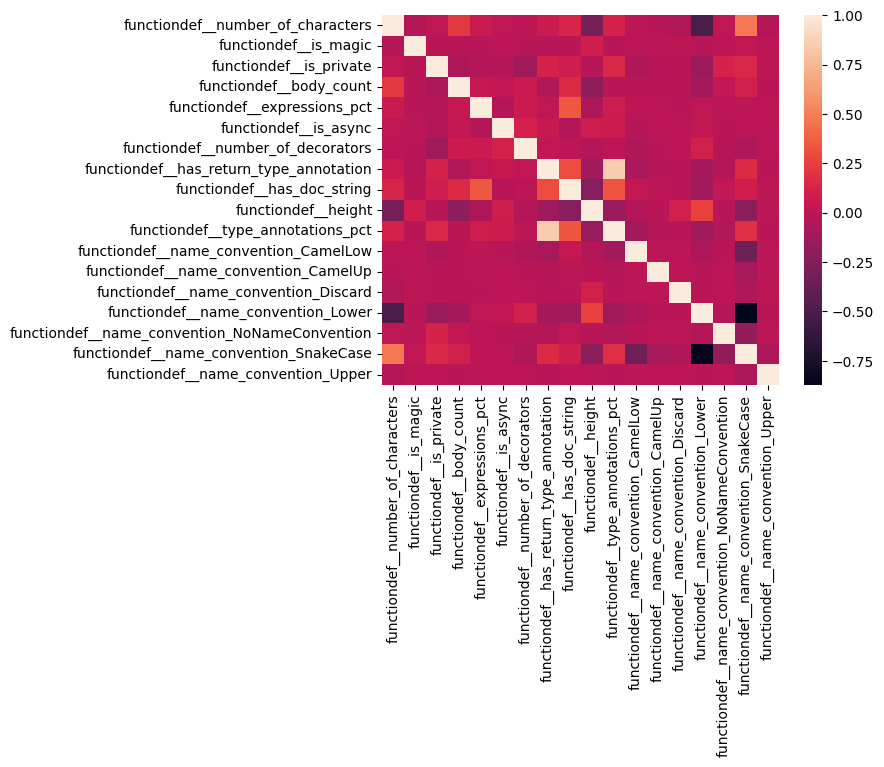

In [10]:
sns.heatmap(X.corr(), annot=False)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 12 variables (2 porcentuales, 4 numericas, 5 booleanas y 1 categorica)

### Variable is_private (1/12)
Esta variable es de tipo booleano y representa si la función es privada.

<Axes: xlabel='functiondef__is_private', ylabel='Count'>

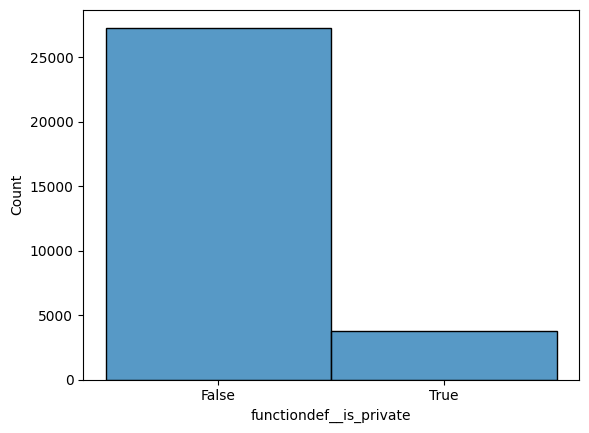

In [11]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_private'], discrete=True)

In [12]:
num_true_values = len(X[X['functiondef__is_private'] == True])
num_false_values = len(X[X['functiondef__is_private'] == False])
std = X['functiondef__is_private'].std()
freq_true = len(X[X['functiondef__is_private'] == True]) / len(X['functiondef__is_private'])
freq_false = len(X[X['functiondef__is_private'] == False]) / len(X['functiondef__is_private'])
print(f'La variable is_private contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_private a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_private a False es {freq_false}.')

La variable is_private contiene 3799 valores verdaderos y 27297 valores falsos. Y, la desviación típica es de 0.32748737931251526
La frecuencia con la que programa puede tener la variable is_private a True es 0.12217005402624131.
La frecuencia con la que programa puede tener la variable is_private a False es 0.8778299459737586.


In [13]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_private', possible_values)

La variable functiondef__is_private contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_private toma el valor de 0.0 en un 87.78% de los items.
La variable functiondef__is_private toma el valor de 1.0 en un 12.22% de los items.


In [14]:
X[X['functiondef__is_private'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,3799.000000,3799.0,3799.0,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.0,3799.0,3799.0,3799.0,3799.000000,3799.000000,3799.000000
mean,17.947618,0.0,1.0,3.963148,0.171190,0.014477,0.042380,0.428007,0.392998,1.251119,0.477296,0.0,0.0,0.0,0.0,0.032903,0.965780,0.001316
std,7.909516,0.0,0.0,4.652904,0.223850,0.119464,0.216595,0.494855,0.488481,0.676552,0.483071,0.0,0.0,0.0,0.0,0.178407,0.181817,0.036259
min,2.000000,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,12.000000,0.0,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000
50%,17.000000,0.0,1.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000
75%,23.000000,0.0,1.0,5.000000,0.333333,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000
max,53.000000,0.0,1.0,172.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000


### Variable is_magic (2/12)
Esta variable es de tipo booleano y representa si la función es de la forma __\w__.

<Axes: xlabel='functiondef__is_magic', ylabel='Count'>

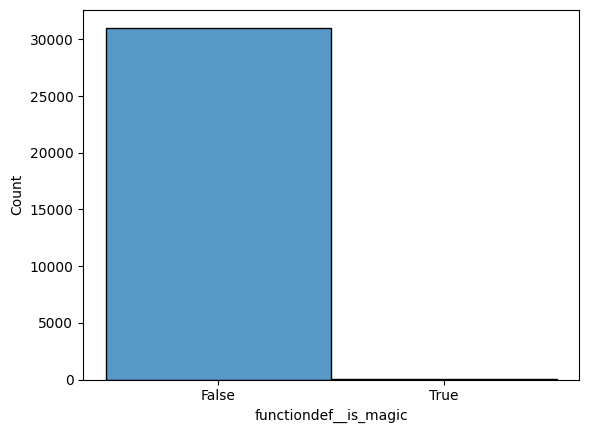

In [15]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_magic'], discrete=True)

In [16]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_magic'] == True])
num_false_values = len(X[X['functiondef__is_magic'] == False])
std = X['functiondef__is_magic'].std()
freq_true = len(X[X['functiondef__is_magic'] == True]) / len(X['functiondef__is_magic'])
freq_false = len(X[X['functiondef__is_magic'] == False]) / len(X['functiondef__is_magic'])
print(f'La variable is_magic contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_magic a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_magic a False es {freq_false}.')

La variable is_magic contiene 55 valores verdaderos y 31041 valores falsos. Y, la desviación típica es de 0.04201957583427429
La frecuencia con la que programa puede tener la variable is_magic a True es 0.0017687162335991767.
La frecuencia con la que programa puede tener la variable is_magic a False es 0.9982312837664008.


In [17]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_magic', possible_values)

La variable functiondef__is_magic contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_magic toma el valor de 0.0 en un 99.82% de los items.
La variable functiondef__is_magic toma el valor de 1.0 en un 0.1769% de los items.


In [18]:
X[X['functiondef__is_magic'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,55.000000,55.0,55.0,55.000000,55.000000,55.0,55.0,55.0,55.000000,55.000000,55.000000,55.0,55.0,55.0,55.0,55.0,55.0,55.0
mean,8.945455,1.0,0.0,2.181818,0.046234,0.0,0.0,0.0,0.181818,2.800000,0.096970,0.0,0.0,0.0,0.0,0.0,1.0,0.0
std,1.532586,0.0,0.0,1.906042,0.097242,0.0,0.0,0.0,0.389249,0.523521,0.261939,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,7.000000,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,8.000000,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,3.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,8.000000,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,3.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,11.000000,1.0,0.0,3.500000,0.000000,0.0,0.0,0.0,0.000000,3.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,12.000000,1.0,0.0,8.000000,0.333333,0.0,0.0,0.0,1.000000,3.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Variable is_async (3/12)
Esta variable es booleana y representa si la función es asincrona.

<Axes: xlabel='functiondef__is_async', ylabel='Count'>

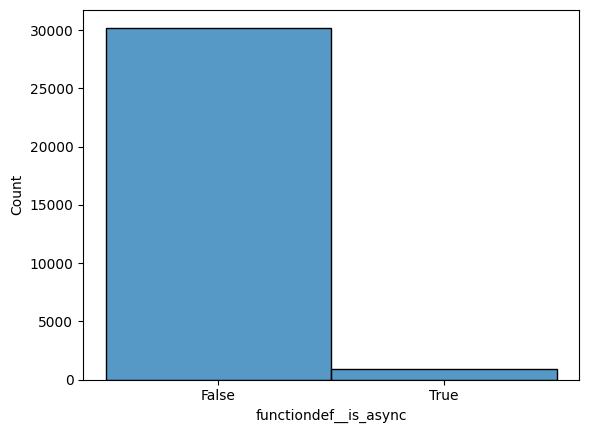

In [19]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_async'], discrete=True)

In [20]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_async'] == True])
num_false_values = len(X[X['functiondef__is_async'] == False])
std = X['functiondef__is_async'].std()
freq_true = len(X[X['functiondef__is_async'] == True]) / len(X['functiondef__is_async'])
freq_false = len(X[X['functiondef__is_async'] == False]) / len(X['functiondef__is_async'])
print(f'La variable is_async contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_async a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_async a False es {freq_false}.')

La variable is_async contiene 888 valores verdaderos y 30208 valores falsos. Y, la desviación típica es de 0.16655969619750977
La frecuencia con la que programa puede tener la variable is_async a True es 0.028556727553383073.
La frecuencia con la que programa puede tener la variable is_async a False es 0.9714432724466169.


In [21]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_async', possible_values)

La variable functiondef__is_async contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_async toma el valor de 0.0 en un 97.14% de los items.
La variable functiondef__is_async toma el valor de 1.0 en un 2.856% de los items.


In [22]:
X[X['functiondef__is_async'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,888.000000,888.0,888.000000,888.000000,888.000000,888.0,888.000000,888.000000,888.000000,888.000000,888.000000,888.0,888.0,888.0,888.000000,888.000000,888.000000,888.0
mean,18.315315,0.0,0.061937,5.795045,0.153977,1.0,0.793919,0.407658,0.197072,1.615991,0.493939,0.0,0.0,0.0,0.195946,0.001126,0.802928,0.0
std,11.459144,0.0,0.241177,6.314092,0.228783,0.0,0.945700,0.491676,0.398011,0.898485,0.470546,0.0,0.0,0.0,0.397151,0.033558,0.398011,0.0
min,1.000000,0.0,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,10.000000,0.0,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0
50%,17.000000,0.0,0.000000,4.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,0.500000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0
75%,25.000000,0.0,0.000000,8.000000,0.250000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0
max,69.000000,0.0,1.000000,59.000000,1.000000,1.0,5.000000,1.000000,1.000000,6.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0


### Variable has_return_type_annotation (4/12)
Esta variable es booleana y representa si la function tiene una anotacion del tipo de retorno.

<Axes: xlabel='functiondef__has_return_type_annotation', ylabel='Count'>

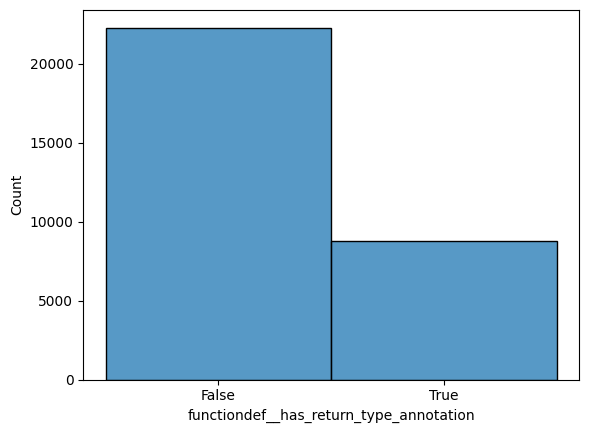

In [23]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_return_type_annotation'], discrete=True)

In [24]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_return_type_annotation'] == True])
num_false_values = len(X[X['functiondef__has_return_type_annotation'] == False])
std = X['functiondef__has_return_type_annotation'].std()
freq_true = len(X[X['functiondef__has_return_type_annotation'] == True]) / len(X['functiondef__has_return_type_annotation'])
freq_false = len(X[X['functiondef__has_return_type_annotation'] == False]) / len(X['functiondef__has_return_type_annotation'])
print(f'La variable has_return_type_annotation contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es {freq_false}.')

La variable has_return_type_annotation contiene 8801 valores verdaderos y 22295 valores falsos. Y, la desviación típica es de 0.4504765570163727
La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es 0.2830267558528428.
La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es 0.7169732441471572.


In [25]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_return_type_annotation', possible_values)

La variable functiondef__has_return_type_annotation contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_return_type_annotation toma el valor de 0.0 en un 71.7% de los items.
La variable functiondef__has_return_type_annotation toma el valor de 1.0 en un 28.3% de los items.


In [26]:
X[X['functiondef__has_return_type_annotation'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,8801.000000,8801.0,8801.000000,8801.000000,8801.000000,8801.000000,8801.000000,8801.0,8801.000000,8801.000000,8801.000000,8801.000000,8801.0,8801.0,8801.000000,8801.000000,8801.000000,8801.0
mean,18.744234,0.0,0.184752,4.543461,0.205622,0.041132,0.326895,1.0,0.515850,1.151460,0.910472,0.002045,0.0,0.0,0.082150,0.000795,0.915010,0.0
std,8.968957,0.0,0.388118,4.522917,0.230538,0.198606,0.617227,0.0,0.499777,0.509802,0.214777,0.045180,0.0,0.0,0.274608,0.028193,0.278883,0.0
min,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,13.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
50%,18.000000,0.0,0.000000,3.000000,0.166667,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
75%,23.000000,0.0,0.000000,5.000000,0.333333,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
max,87.000000,0.0,1.000000,83.000000,1.000000,1.000000,20.000000,1.0,1.000000,6.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0


### Variable has_doc_string (5/12)
Esta variable es booleana y representa si la function comienza por un String plano a modo de comentario.

<Axes: xlabel='functiondef__has_doc_string', ylabel='Count'>

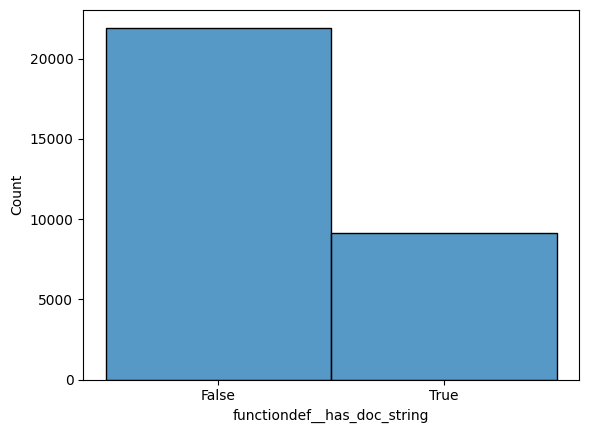

In [27]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_doc_string'], discrete=True)

In [28]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_doc_string'] == True])
num_false_values = len(X[X['functiondef__has_doc_string'] == False])
std = X['functiondef__has_doc_string'].std()
freq_true = len(X[X['functiondef__has_doc_string'] == True]) / len(X['functiondef__has_doc_string'])
freq_false = len(X[X['functiondef__has_doc_string'] == False]) / len(X['functiondef__has_doc_string'])
print(f'La variable has_doc_string contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a False es {freq_false}.')

La variable has_doc_string contiene 9159 valores verdaderos y 21937 valores falsos. Y, la desviación típica es de 0.4558428227901459
La frecuencia con la que programa puede tener la variable has_doc_string a True es 0.29453949060972473.
La frecuencia con la que programa puede tener la variable has_doc_string a False es 0.7054605093902753.


In [29]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_doc_string', possible_values)

La variable functiondef__has_doc_string contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_doc_string toma el valor de 0.0 en un 70.55% de los items.
La variable functiondef__has_doc_string toma el valor de 1.0 en un 29.45% de los items.


In [30]:
X[X['functiondef__has_doc_string'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,9159.000000,9159.000000,9159.000000,9159.000000,9159.000000,9159.000000,9159.000000,9159.000000,9159.0,9159.000000,9159.000000,9159.000000,9159.000000,9159.0,9159.000000,9159.000000,9159.000000,9159.000000
mean,19.748772,0.001092,0.163009,6.270008,0.342494,0.019107,0.311606,0.495687,1.0,1.055028,0.540265,0.036467,0.002074,0.0,0.076318,0.008953,0.874877,0.001310
std,9.682134,0.033026,0.369394,5.944925,0.195386,0.136908,0.933511,0.500009,0.0,0.314577,0.470784,0.187459,0.045501,0.0,0.265521,0.094201,0.330876,0.036175
min,1.000000,0.000000,0.000000,1.000000,0.011628,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,0.000000,3.000000,0.200000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
50%,18.000000,0.000000,0.000000,4.000000,0.333333,0.000000,0.000000,0.000000,1.0,1.000000,0.666667,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,25.000000,0.000000,0.000000,7.000000,0.500000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,70.000000,1.000000,1.000000,172.000000,1.000000,1.000000,46.000000,1.000000,1.0,5.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Variable number_of_characters (6/12)
Esta variable representa el número de caracteres que tiene el nombre de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 87. Con una media de 17.7.

<Axes: ylabel='functiondef__number_of_characters'>

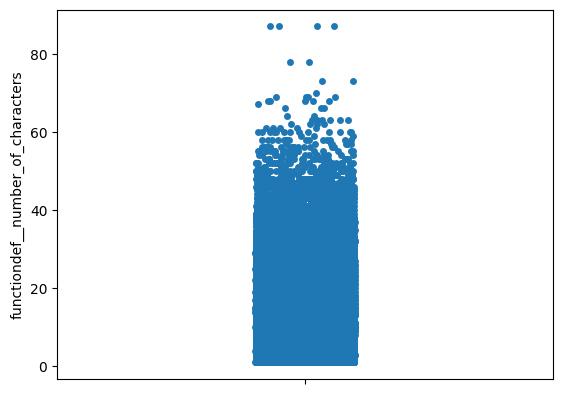

In [31]:
sns.stripplot(X['functiondef__number_of_characters'])

In [32]:
print_outliers_for_df_column(X, 'functiondef__number_of_characters')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.6897114392530879
Rango valores atípicos extremos (Tukey): [-29.0,62.0]
Rango valores atípicos leves (Tukey): [-9.5,42.5]
Rango valores atípicos extremos (Fixed BoxPlot): [8.255575977357811,330.7415239177342]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -29.0 (Q1-3*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -9.5 (Q1-1.5*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
+1.5IQR: 756 instancias tienen un valor para functiondef__number_of_characters superior a 42.5 (Q3+1.5*IQR) para functiondef__number_of_characters. Representando un 2.431% del total de instancias.
+3.0IQR: 31 instancias tienen un valor para functiondef__number_of_characters superior a 62.0 (Q3-3*IQR) para functiondef__number_of_characters. Repre

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 62.0 (Con un MC de 68 usamos Tuckey Extremo)

In [33]:
X[X['functiondef__number_of_characters'] > 62].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,31.000000,31.0,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0,31.000000,31.0,31.0,31.0,31.0,31.0,31.0,31.0
mean,70.000000,0.0,0.0,9.129032,0.178829,0.096774,0.548387,0.354839,0.129032,1.0,0.451613,0.0,0.0,0.0,0.0,0.0,1.0,0.0
std,7.741662,0.0,0.0,7.251400,0.309577,0.300537,0.925156,0.486373,0.340777,0.0,0.505879,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,63.000000,0.0,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,64.000000,0.0,0.0,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,68.000000,0.0,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,71.500000,0.0,0.0,9.000000,0.208333,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,87.000000,0.0,0.0,40.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### IMPORTANTE
Hay que revisar los 4 con nombres de mas de 80 caracteres

### Variable body_count (7/12)
Esta variable representa el número de sentencias en el root de la función. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 172. Con una media de 4.96.

<Axes: ylabel='functiondef__body_count'>

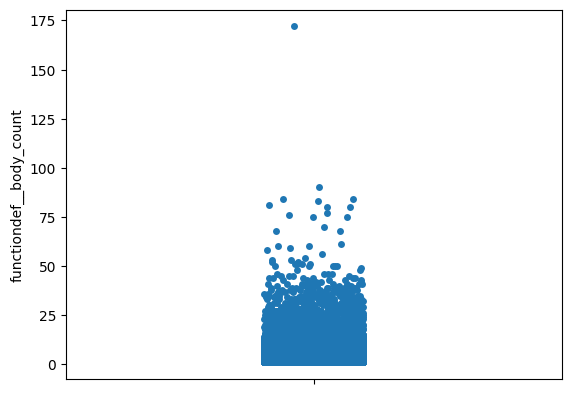

In [34]:
sns.stripplot(X['functiondef__body_count'])

### IMPORTANTE
El valor máximo está muy alejado del siguiente.

In [35]:
print_outliers_for_df_column(X, 'functiondef__body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7046413068251057
Rango valores atípicos extremos (Tukey): [-10.0,18.0]
Rango valores atípicos leves (Tukey): [-4.0,12.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.4905813496194043,106.5167817884299]
-3.0IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -10.0 (Q1-3*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -4.0 (Q1-1.5*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
+1.5IQR: 2239 instancias tienen un valor para functiondef__body_count superior a 12.0 (Q3+1.5*IQR) para functiondef__body_count. Representando un 7.2% del total de instancias.
+3.0IQR: 902 instancias tienen un valor para functiondef__body_count superior a 18.0 (Q3-3*IQR) para functiondef__body_count. Representando un 2.901% del total de instancias.
L: 6255 instancias tienen un valor 

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 18.0 (Con un MC de 70 usamos Tuckey Extremo)

In [36]:
X[X['functiondef__body_count'] > 18].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,902.000000,902.0,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.0,902.0,902.000000,902.000000,902.000000,902.0
mean,22.880266,0.0,0.035477,27.212860,0.238590,0.048780,0.490022,0.159645,0.400222,1.015521,0.209051,0.012195,0.0,0.0,0.093126,0.007761,0.886918,0.0
std,11.362411,0.0,0.185084,11.115733,0.213445,0.215528,0.983442,0.366480,0.490215,0.148177,0.395117,0.109817,0.0,0.0,0.290771,0.087800,0.316869,0.0
min,3.000000,0.0,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,15.000000,0.0,0.000000,21.000000,0.064516,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
50%,22.000000,0.0,0.000000,24.000000,0.190476,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
75%,30.000000,0.0,0.000000,30.000000,0.363636,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0
max,66.000000,0.0,1.000000,172.000000,1.000000,1.000000,11.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0


### IMPORTANTE
Hay que revisar el que tiene mas de 100.

### Variable number_of_decorators (8/12)
Esta variable representa el número de decoradores de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 46. Con una media de 0.31.

<Axes: ylabel='functiondef__number_of_decorators'>

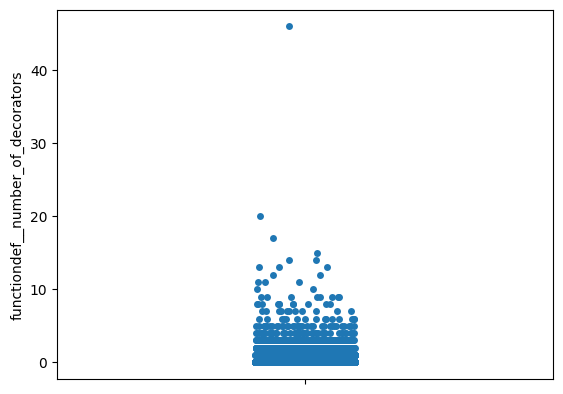

In [37]:
sns.stripplot(X['functiondef__number_of_decorators'])

### IMPORTANTE
El valor máximo está muy alejado del siguiente.

In [38]:
print_outliers_for_df_column(X, 'functiondef__number_of_decorators')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.674582120841106
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.14148348042380732,23.28232117139645]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a -3.0 (Q1-3*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a -1.5 (Q1-1.5*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
+1.5IQR: 379 instancias tienen un valor para functiondef__number_of_decorators superior a 2.5 (Q3+1.5*IQR) para functiondef__number_of_decorators. Representando un 1.219% del total de instancias.
+3.0IQR: 97 instancias tienen un valor para functiondef__number_of_decorators superior a 4.0 (Q3-3*IQR) para functiondef__number_of_decorators. Represent

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 4.0 (Con un MC de 67 usamos Tuckey Extremo)

In [39]:
X[X['functiondef__number_of_decorators'] > 4.0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,97.000000,97.0,97.0,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.000000,97.0,97.0,97.0,97.000000,97.0,97.000000,97.0
mean,10.484536,0.0,0.0,9.195876,0.370027,0.020619,7.721650,0.082474,0.443299,1.0,0.585435,0.0,0.0,0.0,0.505155,0.0,0.494845,0.0
std,8.976954,0.0,0.0,7.536908,0.323613,0.142842,4.923884,0.276515,0.499355,0.0,0.477151,0.0,0.0,0.0,0.502571,0.0,0.502571,0.0
min,2.000000,0.0,0.0,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
25%,4.000000,0.0,0.0,4.000000,0.142857,0.000000,5.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
50%,7.000000,0.0,0.0,7.000000,0.300000,0.000000,6.000000,0.000000,0.000000,1.0,0.909091,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0
75%,13.000000,0.0,0.0,12.000000,0.500000,0.000000,8.000000,0.000000,1.000000,1.0,1.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0
max,50.000000,0.0,0.0,39.000000,1.000000,1.000000,46.000000,1.000000,1.000000,1.0,1.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0


### IMPORTANTE
El 74% de las funciones no tienen decoradores.

Hay que revisar el que tiene 46

### Variable height (9/12)
Esta variable representa la distancia desde la función hasta el root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 10. Con una media de 1.3.

<Axes: ylabel='functiondef__height'>

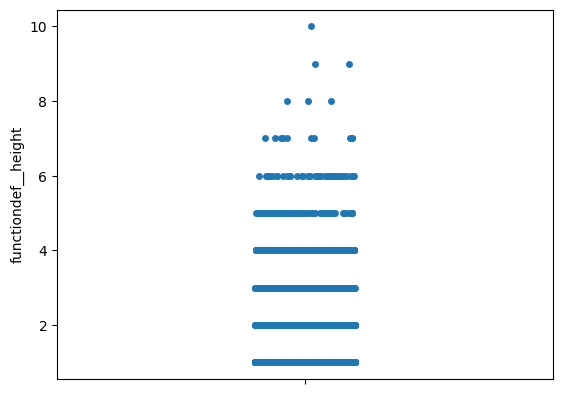

In [40]:
sns.stripplot(X['functiondef__height'])

In [41]:
print_outliers_for_df_column(X, 'functiondef__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 1.0
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 0 instancias tienen un valor para functiondef__height inferior a 1.0 (Q1-3*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__height inferior a 1.0 (Q1-1.5*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
+1.5IQR: 6291 instancias tienen un valor para functiondef__height superior a 1.0 (Q3+1.5*IQR) para functiondef__height. Representando un 20.23% del total de instancias.
+3.0IQR: 6291 instancias tienen un valor para functiondef__height superior a 1.0 (Q3-3*IQR) para functiondef__height. Representando un 20.23% del total de instancias.
L: 0 instancias tienen un valor para functiondef__height inferior a 1.0 para functiondef__height. Representando un 0.0

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 1.0 (Todos los umbrales son 1)

In [42]:
X[X['functiondef__height'] > 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000,6291.000000
mean,10.522333,0.008266,0.092354,2.515339,0.158684,0.053410,0.284851,0.133842,0.050866,2.517565,0.153592,0.012240,0.001431,0.003815,0.370688,0.002543,0.608170,0.001113
std,7.159767,0.090547,0.289548,2.341350,0.301062,0.224867,0.459755,0.340510,0.219742,0.765389,0.348751,0.109963,0.037799,0.061652,0.483027,0.050371,0.488198,0.033341
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.000000,0.000000,0.000000,3.000000,0.200000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,50.000000,1.000000,1.000000,29.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### IMPORTANTE
Hay 3 funciones con altura mayor que 8, hay que revisarlas.

### Variable expressions_pct (10/12)
Esta variable representa la proporción de las sentencias en el root de la funcion que son expresiones. Toma los valores de 0.0 - 1.0. La media es 0.20.

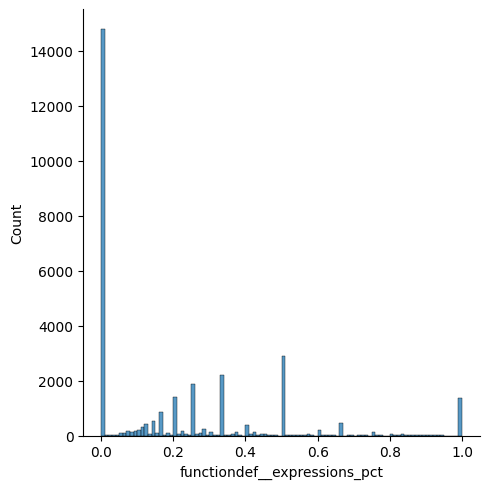

In [43]:
sns.displot(X['functiondef__expressions_pct'], bins=[i / 100 for i in range(0, 101)])

In [44]:
print_outliers_for_df_column(X, 'functiondef__expressions_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.531400401804774
Rango valores atípicos extremos (Tukey): [-1.0000000298023224,1.3333333730697632]
Rango valores atípicos leves (Tukey): [-0.5000000149011612,0.833333358168602]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.07784399205126286,4.522301567714109]
-3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -1.0000000298023224 (Q1-3*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -0.5000000149011612 (Q1-1.5*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 1459 instancias tienen un valor para functiondef__expressions_pct superior a 0.833333358168602 (Q3+1.5*IQR) para functiondef__expressions_pct. Representando un 4.692% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct superio

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0.83 (Con un MC de 0.53 usamos Tuckey)

In [45]:
X[X['functiondef__expressions_pct'] > 0.83].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,1501.000000,1501.0,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000
mean,16.077282,0.0,0.057295,2.744837,0.988709,0.020653,0.383744,0.159227,0.197202,1.536309,0.302118,0.009327,0.000666,0.000666,0.226516,0.000666,0.761492,0.000666
std,11.322634,0.0,0.232483,4.247138,0.037794,0.142267,0.866781,0.366010,0.398019,0.875318,0.454016,0.096158,0.025811,0.025811,0.418716,0.025811,0.426313,0.025811
min,1.000000,0.0,0.000000,1.000000,0.833333,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,13.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,21.000000,0.0,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,68.000000,0.0,1.000000,77.000000,1.000000,1.000000,12.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### IMPORTANTE
El 47% tienen un 0% y el 4% un 100% de expresiones.

### Variable type_annotations_pct (11/12)
Esta variable representa la proporción de los parámetros que tienen anotación de tipo en la función (incluyendo el return). Este campo toma valores del 0.0 - 1.0. Su media es 0.31.

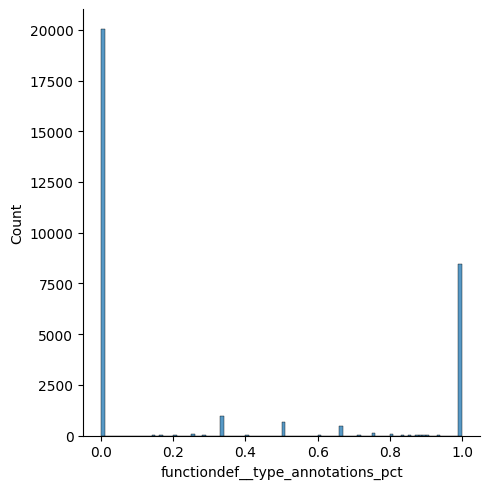

In [46]:
sns.displot(X['functiondef__type_annotations_pct'], bins=[i / 100 for i in range(0, 101)])

In [47]:
print_outliers_for_df_column(X, 'functiondef__type_annotations_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.24338340759277344
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.6399425844391823,4.970923703249973]
-3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -3.0 (Q1-3*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -1.5 (Q1-1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 2.5 (Q3+1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 4.0 (Q3-3*IQR) para functiondef__type_annotations_pct. Representando

In [48]:
X[X['functiondef__type_annotations_pct'] > 0.0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Discard,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase,functiondef__name_convention_Upper
count,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.000000,11072.0,11072.000000,11072.000000,11072.000000,11072.000000
mean,19.083906,0.000632,0.174404,4.763186,0.224451,0.044346,0.348447,0.794888,0.497832,1.153992,0.879418,0.001626,0.000090,0.0,0.082009,0.000903,0.915282,0.000090
std,9.309922,0.025137,0.379474,4.679398,0.253059,0.205872,0.818873,0.403802,0.500018,0.521461,0.233183,0.040289,0.009504,0.0,0.274390,0.030041,0.278474,0.009504
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.052632,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
50%,18.000000,0.000000,0.000000,3.000000,0.166667,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,24.000000,0.000000,0.000000,6.000000,0.333333,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,87.000000,1.000000,1.000000,83.000000,1.000000,1.000000,20.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### IMPORTANTE
El 64% tienen un 0% y el 27% un 100% de anotaciones de tipo.

### Variable name_convention (12/22)
Esta variable es de tipo categórica y representa la name_convention del nombre de la funcion.

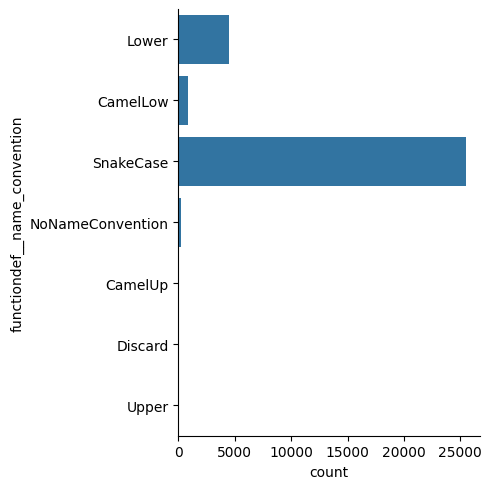

In [49]:
sns.catplot(full_table['functiondef__name_convention'], kind="count")

In [50]:
print_frequency_anal_for_cat_var(full_table, 'functiondef__name_convention')

La variable functiondef__name_convention contiene 7 valores distintos.
El umbral de outlier es de 0.028571428571428574%
La variable functiondef__name_convention toma el valor de SnakeCase en un 81.93% de los items.
La variable functiondef__name_convention toma el valor de Lower en un 14.35% de los items.
La variable functiondef__name_convention toma el valor de CamelLow en un 2.66% de los items.
La variable functiondef__name_convention toma el valor de NoNameConvention en un 0.6592% de los items.
La variable functiondef__name_convention toma el valor de CamelUp en un 0.2122% de los items.
La variable functiondef__name_convention toma el valor de Upper en un 0.1126% de los items.
La variable functiondef__name_convention toma el valor de Discard en un 0.0804% de los items.


## Multivariate

TODO: isolation forest algorithm

In [51]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,functiondef_id,functiondef__name_convention,functiondef__number_of_characters,functiondef__is_private,functiondef__is_magic,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__expertise_level
25601,4603375,NoNameConvention,19,True,False,4,0.000000,False,0,False,False,4,0.000000,EXPERT
25602,4602722,NoNameConvention,16,True,False,5,0.000000,False,0,False,False,4,0.000000,EXPERT
25621,4593113,NoNameConvention,17,True,False,17,0.117647,False,0,False,True,1,0.000000,EXPERT
25844,4524550,NoNameConvention,17,True,False,8,0.500000,False,0,False,True,1,0.000000,EXPERT
25851,4523827,NoNameConvention,19,True,False,13,0.230769,False,0,False,True,1,0.000000,EXPERT
26071,4498858,NoNameConvention,22,True,False,70,0.000000,False,0,False,False,1,0.000000,EXPERT
26083,4495408,NoNameConvention,25,True,False,6,0.166667,False,0,False,True,1,0.000000,EXPERT
26089,4497788,NoNameConvention,19,True,False,16,0.250000,False,0,False,True,1,0.000000,EXPERT
26090,4496915,NoNameConvention,27,True,False,172,0.011628,False,0,False,True,1,0.000000,EXPERT
26091,4496798,NoNameConvention,18,True,False,30,0.066667,False,0,False,True,1,0.000000,EXPERT


### IMPORTANTE
Hay que analizar los 38 los outliers de la tabla.